In [1]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx
import sys
from scipy.stats import mode
from scipy.optimize import curve_fit
from scipy.integrate import trapz
import json
from scipy.stats import lognorm

sys.path.append("./models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *


jax.config.update("jax_enable_x64", True)

%matplotlib inline
# plt.style.use('/home/nlinden/.matplotlib/custom.mplstyle')
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *
from utils import *

%env CUDA_VISIBLE_DEVICES=1


env: CUDA_VISIBLE_DEVICES=1


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def simulate_model_trajectory(model_instance, y0, params, t1=300, dt0=1e-3, n_out=1000, times=None):
    """ simulates a model over the specified time interval and returns the 
    trajectory of the model state variables."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3
    if times is None:
        times = np.linspace(t0, t1, n_out)
    else:
        t1 = times[-1]
    
    saveat = saveat=diffrax.SaveAt(ts=times)

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        saveat=saveat, stepsize_controller=stepsize_controller,
        args=tuple(params),
        max_steps=60000,
        throw=False,)
    
    return sol

def simulate_model_steady_state(model_instance, y0, params, t1=300, dt0=1e-3, 
    event_rtol=1e-6, event_atol=1e-6):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=tuple(params),
        max_steps=None,
        throw=True,)
    
    return sol


# Generate synthetic data using the Huang and Ferrell 1996 Model

In [3]:
# run series of simulations to generate stimulus response curves
hf_1996 = huang_ferrell_1996(transient=True)
y0_dict, y0 = hf_1996.get_initial_conditions()
p_dict, plist = hf_1996.get_nominal_params()

# rescale params to make dynamics more physiological
p_scale = np.ones_like(np.array(plist))
p_scale[0:30]=0.075 # only scale rate params k_i, d_i and a_i
plist = p_scale*np.array(plist)

ss = []
ss_traj = []
E1_vals = np.logspace(-6.00, -3.75, 10, endpoint=False)
times = np.linspace(0, 30*60, 240) # note model is in seconds
print(E1_vals)
for i, E1 in enumerate(E1_vals):
    # update params with new stimulus
    y0_dict['E1'] = E1
    y0 = tuple([y0_dict[k] for k in y0_dict.keys()])
    # run to steady-state
    sol = simulate_model_steady_state(hf_1996, y0, plist, t1=1000, event_rtol=1e-10, event_atol=1e-10)
    sol_traj = simulate_model_trajectory(hf_1996, y0, plist, times=times)
    ss.append(sol)
    ss_traj.append(sol_traj)

# process results
pred_mapk = np.array([s.ys[-1]+s.ys[-2] for s in ss])

[1.00000000e-06 1.67880402e-06 2.81838293e-06 4.73151259e-06
 7.94328235e-06 1.33352143e-05 2.23872114e-05 3.75837404e-05
 6.30957344e-05 1.05925373e-04]


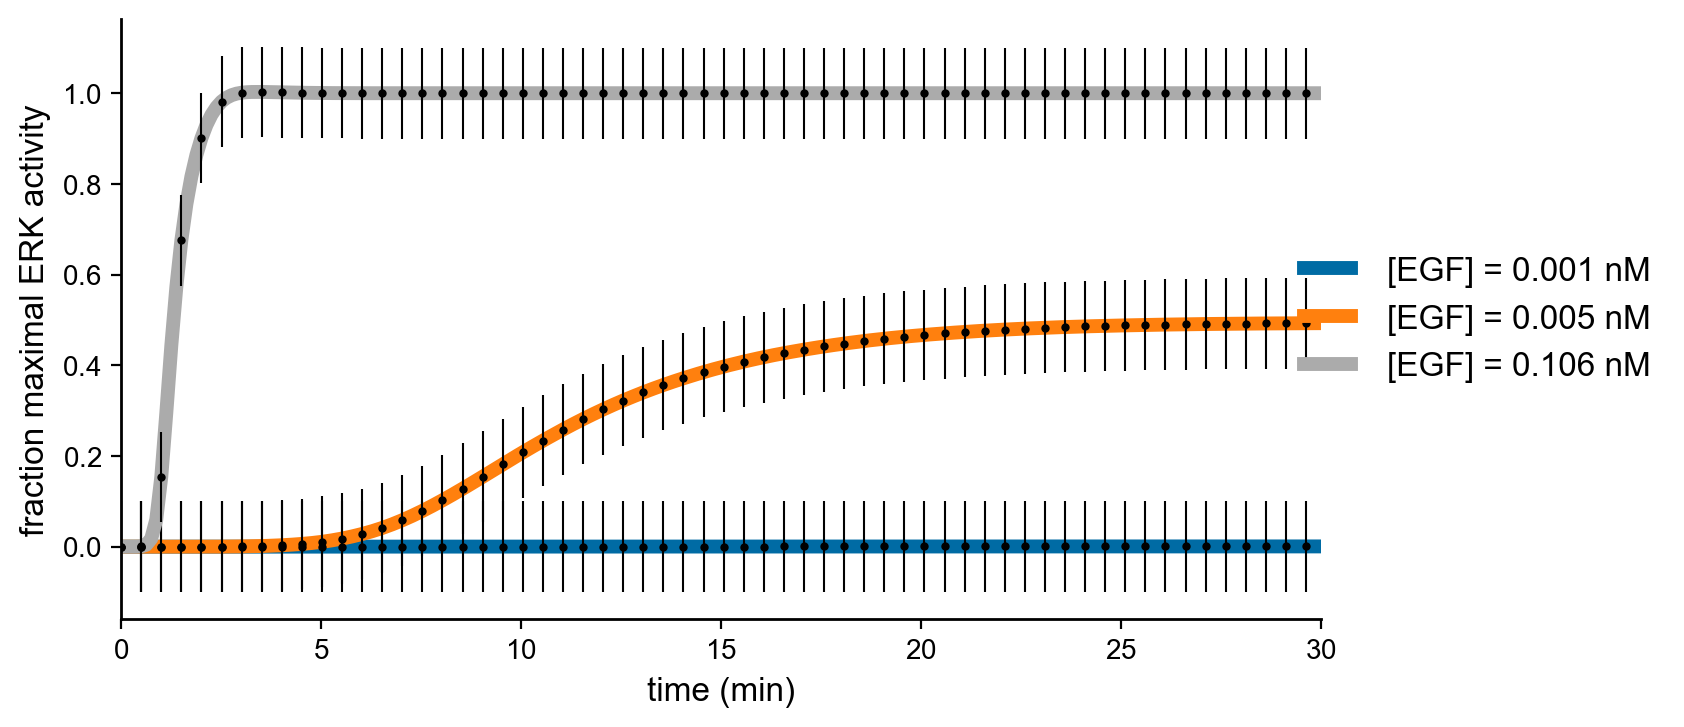

In [9]:
fig, ax = get_sized_fig_ax(6.0, 3.0)

errors = []

# error percentage
error_strength = 0.1

val_list = []
error_list = []

for i in [0,3,-1]:
    vals = (ss_traj[i].ys[-1]+ss_traj[i].ys[-2])/pred_mapk[-1]
    val_list.append(list(np.array(vals)))

    # compute error
    error = error_strength*np.ones_like(vals)
    error_list.append(list(np.array(error)))

    ax.plot(ss_traj[i].ts/60, vals, label='[EGF] = {:.3f} nM'.format(1000*E1_vals[i]), linewidth=5.0)
    ax.errorbar(ss_traj[i].ts[::4]/60, vals[::4], error[::4], fmt='o', markersize=2, color='k', linewidth=0.75)

    # save traj data
    df = pd.DataFrame({'stimulus': 1000*E1_vals[i], 'response': vals, 'time': times, 'response_std': error})
    df.to_csv('../../results/MAPK/HF_96_traj_EGF_{:.3f}.csv'.format(1000*E1_vals[i]), index=False)

ax.set_xlabel('time (min)')
ax.set_ylabel('fraction maximal ERK activity')
ax.set_xlim([0.0,max(times)/60])
ax.legend(loc='right', bbox_to_anchor=(1.3,0.5))

In [29]:
# save all data at once
# save traj data
data = {'stimulus': [1000*E1_vals[i] for i in [0,3,-1]], 'response': np.array(val_list)[:,::4].tolist(), 'time': times[::4].tolist(), 'response_std': np.array(error_list)[:, ::4].tolist()}
with open('../../results/MAPK/HF_96_traj_data.json','w') as data_file:
    json.dump(data, data_file)

### Save trajectories

In [7]:
# process results
erk_acts = []
for i in range(len(ss_traj)):
    erk_acts.append([ss_traj[i].ys[-1]+ss_traj[i].ys[-2]])
erk_acts = np.array(erk_acts)

np.save('../../results/MAPK/HF_96_trajs.npy', erk_acts)
np.save('../../results/MAPK/HF_96_traj_times.npy', np.linspace(0, 1000, 1000))

### Now normalize to the maximum response

$$
\frac{{\rm Response}}{{\rm Response}_{\rm max}}
$$

Assume noise with a standard deviation of $0.1$.

**Note the below dose-response data is with the nominal params given in the huang_ferrell_1996..py file**

(10,)


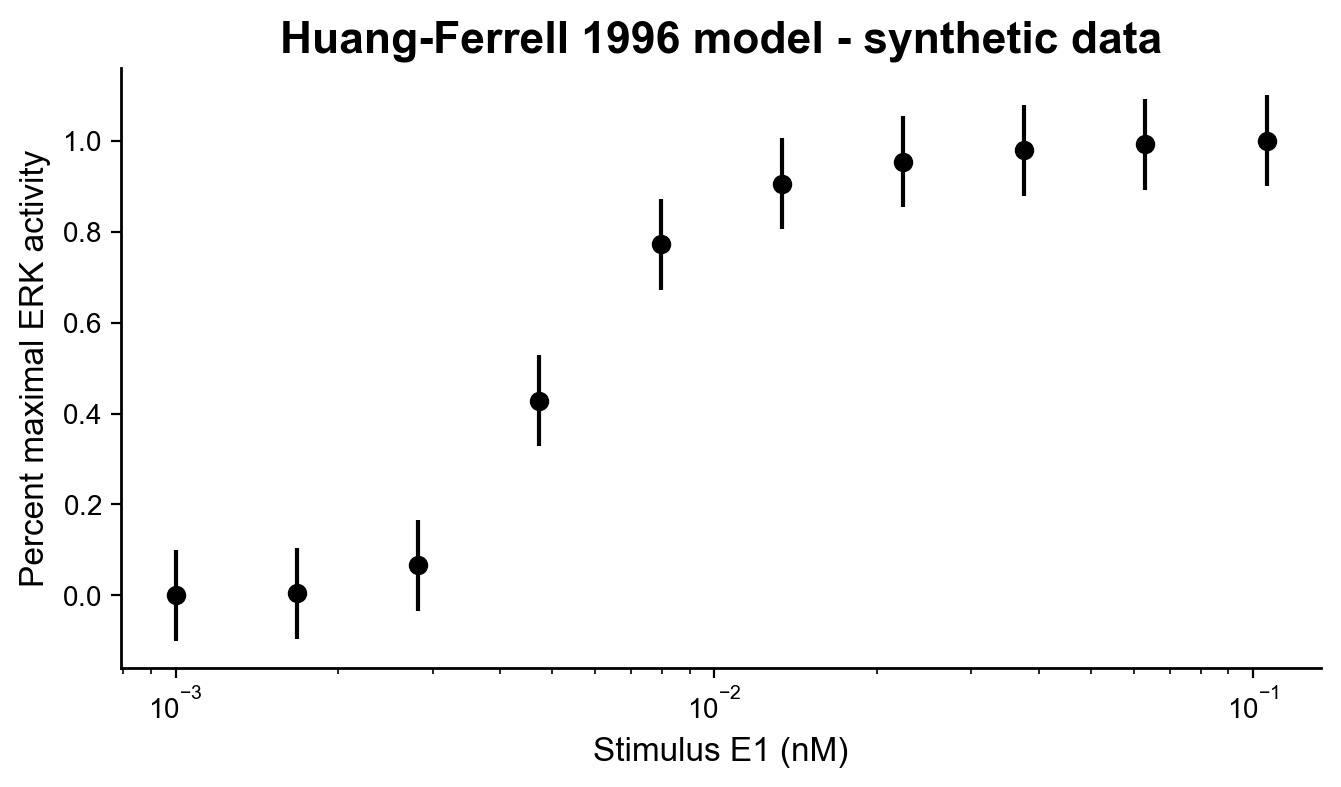

In [8]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
errors = 0.1*np.squeeze(np.ones_like(pred_mapk))
errors.shape
print(E1_vals.shape)
ax.errorbar(1000*E1_vals, np.squeeze(pred_mapk)/pred_mapk[-1], yerr=errors, color='k', label='MAPKKK', fmt='o')
ax.set_xlabel('Stimulus E1 (nM)')
ax.set_ylabel('Percent maximal ERK activity')
ax.set_xscale('log')
ax.set_title('Huang-Ferrell 1996 model - synthetic data')
fig.savefig('../../figures/MAPK/HF_96_synthetic_data.pdf', bbox_inches='tight', transparent=True)

### Export the stimulus response curve to use for inference

In [90]:
# PERCENT MAXIMAL ACTIVITY
normalized_stim_resp = np.squeeze(pred_mapk)/pred_mapk[-1]
stimulus_vals_nM = 1000*E1_vals

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM, 'response': normalized_stim_resp})
df.to_csv('../../results/MAPK/HF_96_synthetic_data.csv', index=False)

# PERCENT TOTAL MAPK ACTIVCE
normalized_stim_resp = np.squeeze(pred_mapk)/hf_1996.get_total_ERK(plist, y0)
stimulus_vals_nM = 1000*E1_vals

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM, 'response': normalized_stim_resp})
df.to_csv('../../results/MAPK/HF_96_synthetic_data_TotalMAPKnorm.csv', index=False)

# Generate Synthetic data from XYZ MODEL

# Process data from Santos 2007

In [32]:
means = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2C.csv')
EGF_0 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0.csv')
EGF_0_001 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0_001.csv')
EGF_0_01 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0_01.csv')
EGF_0_1 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0_1.csv')
EGF_1 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_1.csv')
EGF_3 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_3.csv')
EGF_5 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_5.csv')
EGF_10 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_1.csv')
EGF_30 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_30.csv')
EGF_50 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_50.csv')
EGF_100 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_10.csv')

### Explore the raw data

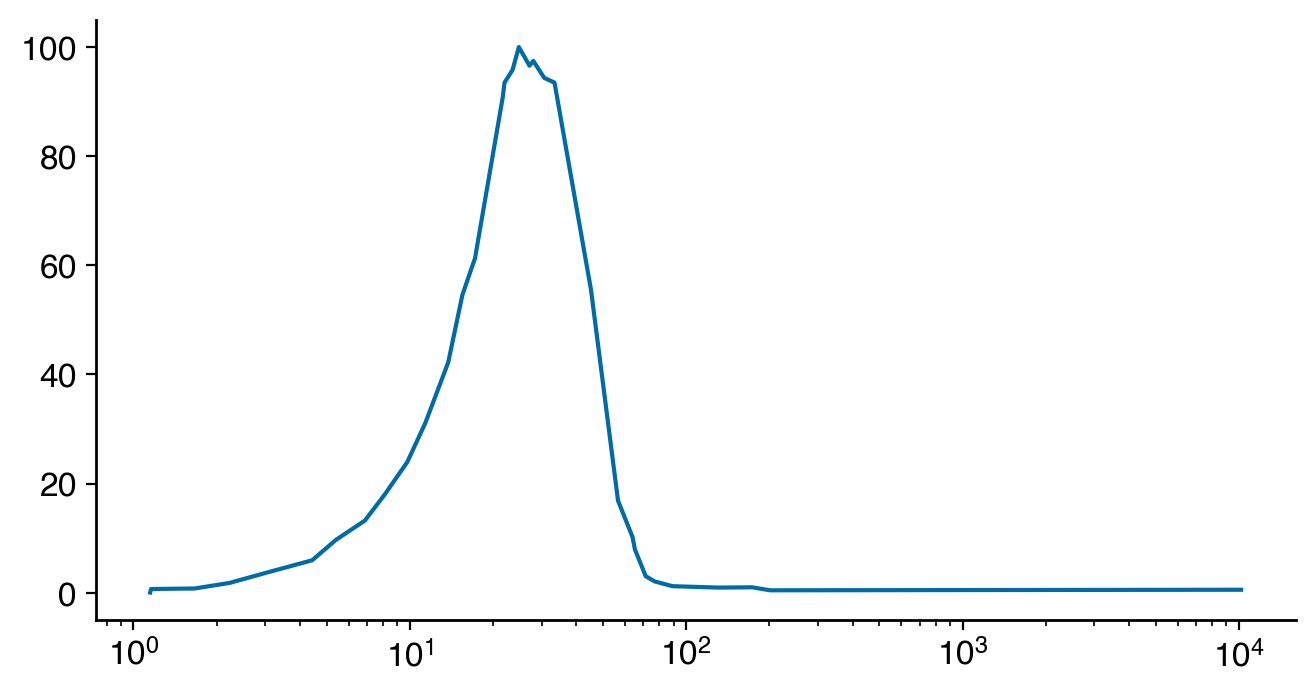

In [33]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
# ax.plot(EGF_0['x'], EGF_0[' y'], label='EGF=0')
# ax.plot(EGF_0_001['x'], EGF_001[' y'], label='EGF=0.001')
# ax.plot(EGF_0_01['x'], EGF_01[' y'], label='EGF=0.01')
# ax.plot(EGF_0_1['x'], EGF_0_1[' y'], label='EGF=0.1')
# ax.plot(EGF_1['x'], EGF_1[' y'], label='EGF=1')
# ax.plot(EGF_3['x'], EGF_3[' y'], label='EGF=3')
# ax.plot(EGF_5['x'], EGF_5[' y'], label='EGF=5')
# ax.plot(EGF_10['x'], EGF_10[' y'], label='EGF=10')
# ax.plot(EGF_30['x'], EGF_30[' y'], label='EGF=30')
# ax.plot(EGF_50['x'], EGF_50[' y'], label='EGF=50')
ax.plot(EGF_100['x'], EGF_100[' y'], label='EGF=100')
ax.set_xscale('log')

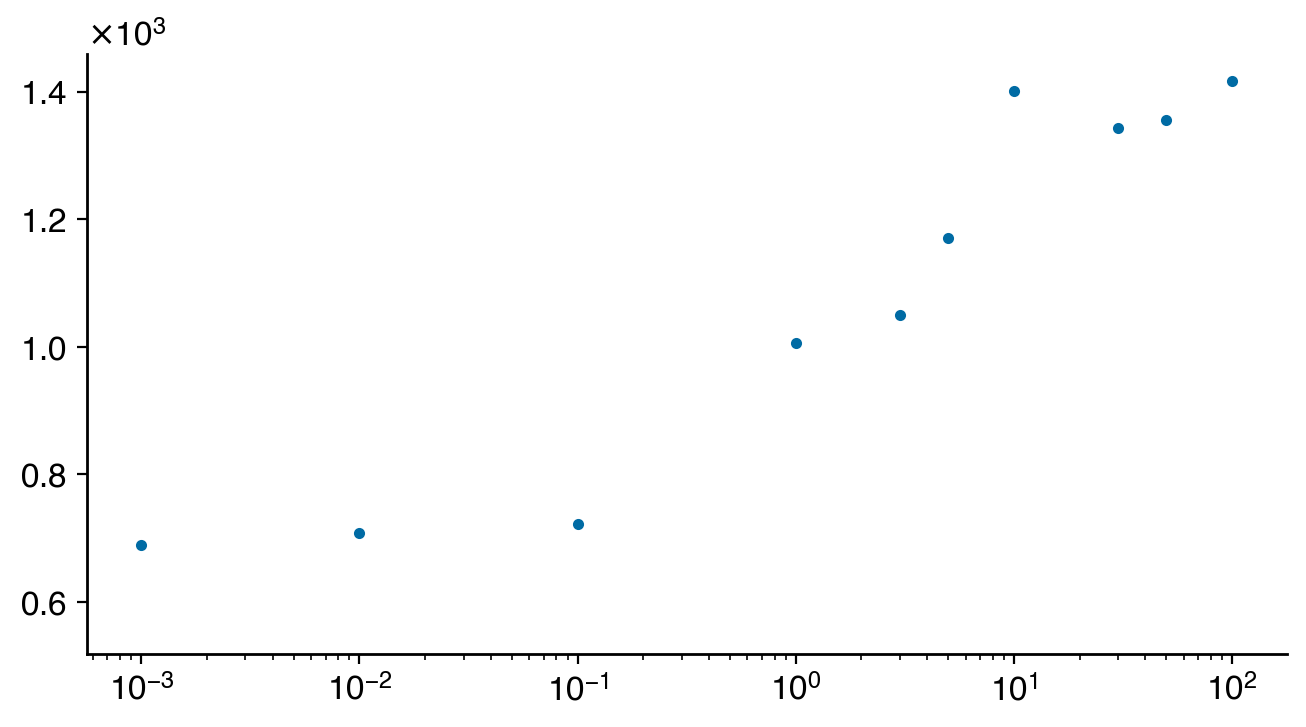

In [34]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
ax.plot(means['EGF (ng/ml)'], means['ppERK1/2 (a.u.)'], '.')
ax.set_xscale('log')

[3.24409302 0.48179623]
[1.65892647 0.44416554]
[2.85226081 0.51091952]


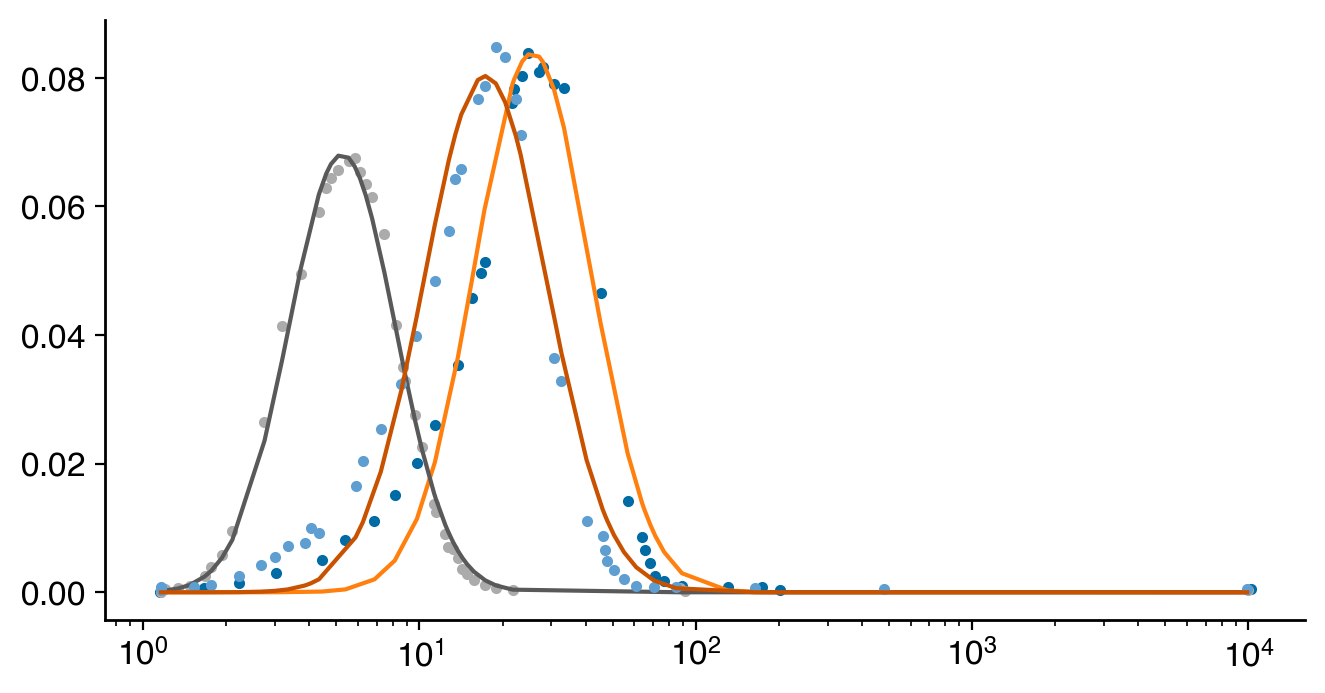

In [35]:
lognorm_pdf = lambda x, mu, sigma: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/trapz(1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2)))
norm_pdf = lambda x, mu, sigma: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))/trapz(1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2)))

results = curve_fit(norm_pdf, np.log(EGF_100['x']), EGF_100[' y']/trapz(EGF_100[' y']), p0=[2.5, 1], maxfev=10000)
print(results[0])
fig, ax = get_sized_fig_ax(6.0, 3.0)
ax.plot(EGF_100['x'], EGF_100[' y']/trapz(EGF_100[' y']), '.')
ax.plot(EGF_100['x'], norm_pdf(np.log(EGF_100['x']), *results[0])/trapz(norm_pdf(np.log(EGF_100['x']), *results[0])))

results = curve_fit(norm_pdf, np.log(EGF_0_001['x']), EGF_0_001[' y']/trapz(EGF_0_001[' y']), p0=[2.5, 1], maxfev=10000)
print(results[0])
ax.plot(EGF_0_001['x'], EGF_0_001[' y']/trapz(EGF_0_001[' y']), '.')
ax.plot(EGF_0_001['x'], norm_pdf(np.log(EGF_0_001['x']), *results[0])/trapz(norm_pdf(np.log(EGF_0_001['x']), *results[0])))

results = curve_fit(norm_pdf, np.log(EGF_5['x']), EGF_5[' y']/trapz(EGF_5[' y']), p0=[2.5, 1], maxfev=10000)
print(results[0])
ax.plot(EGF_5['x'], EGF_5[' y']/trapz(EGF_5[' y']), '.')
ax.plot(EGF_5['x'], norm_pdf(np.log(EGF_5['x']), *results[0])/trapz(norm_pdf(np.log(EGF_5['x']), *results[0])))
ax.set_xscale('log')


In [36]:
lognorm_pdf = lambda x, mu, sigma: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/trapz(1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2)))

results_0 = curve_fit(lognorm_pdf, EGF_0['x'], EGF_0[' y']/trapz(EGF_0[' y']), p0=[2.5, 1], maxfev=10000)
var_0 = lognorm(s=results_0[0][1], scale=np.exp(results_0[0][0])).var()
results_0_001 = curve_fit(lognorm_pdf, EGF_0_001['x'], EGF_0_001[' y']/trapz(EGF_0_001[' y']), p0=[2.5, 1], maxfev=10000)
var_0_001 = lognorm(s=results_0_001[0][1], scale=np.exp(results_0_001[0][0])).var()
results_0_01 = curve_fit(lognorm_pdf, EGF_0_01['x'], EGF_0_01[' y']/trapz(EGF_0_01[' y']), p0=[2.5, 1], maxfev=10000)
var_0_01 = lognorm(s=results_0_01[0][1], scale=np.exp(results_0_01[0][0])).var()
results_0_1 = curve_fit(lognorm_pdf, EGF_0_1['x'], EGF_0_1[' y']/trapz(EGF_0_1[' y']), p0=[2.5, 1], maxfev=10000)
var_0_1 = lognorm(s=results_0_1[0][1], scale=np.exp(results_0_1[0][0])).var()
results_1 = curve_fit(lognorm_pdf, EGF_1['x'], EGF_1[' y']/trapz(EGF_1[' y']), p0=[2.5, 1], maxfev=10000)
var_1 = lognorm(s=results_1[0][1], scale=np.exp(results_1[0][0])).var()
results_3 = curve_fit(lognorm_pdf, EGF_3['x'], EGF_3[' y']/trapz(EGF_3[' y']), p0=[2.5, 1], maxfev=10000)
var_3 = lognorm(s=results_3[0][1], scale=np.exp(results_3[0][0])).var()
results_5 = curve_fit(lognorm_pdf, EGF_5['x'], EGF_5[' y']/trapz(EGF_5[' y']), p0=[2.5, 1], maxfev=10000)
var_5 = lognorm(s=results_5[0][1], scale=np.exp(results_5[0][0])).var()
results_10 = curve_fit(lognorm_pdf, EGF_10['x'], EGF_10[' y']/trapz(EGF_10[' y']), p0=[2.5, 1], maxfev=10000)
var_10 = lognorm(s=results_10[0][1], scale=np.exp(results_10[0][0])).var()
results_30 = curve_fit(lognorm_pdf, EGF_30['x'], EGF_30[' y']/trapz(EGF_30[' y']), p0=[2.5, 1], maxfev=10000)
var_30 = lognorm(s=results_30[0][1], scale=np.exp(results_30[0][0])).var()
results_50 = curve_fit(lognorm_pdf, EGF_50['x'], EGF_50[' y']/trapz(EGF_50[' y']), p0=[2.5, 1], maxfev=10000)
var_50 = lognorm(s=results_50[0][1], scale=np.exp(results_50[0][0])).var()
results_100 = curve_fit(lognorm_pdf, EGF_100['x'], EGF_100[' y']/trapz(EGF_100[' y']), p0=[2.5, 1], maxfev=10000)
var_100 = lognorm(s=results_100[0][1], scale=np.exp(results_100[0][0])).var()

### Now normalize to the maximum response

$$
\frac{{\rm Response}}{{\rm Response}_{\rm max}}
$$

Assume noise with a standard deviation of $0.1$.

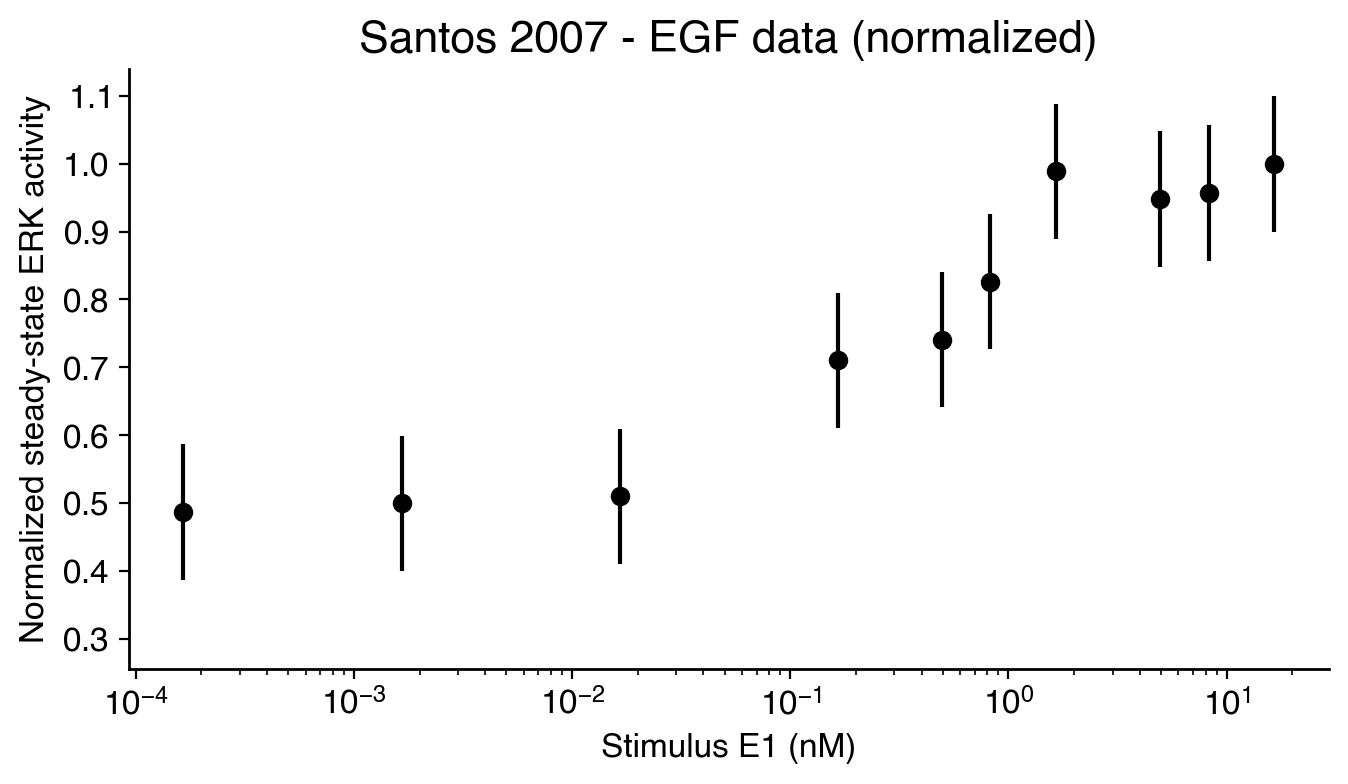

In [38]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
ng_ml_nM_convert = 6.048
# errors = np.array([var_0, var_0_001, var_0_01, var_0_1, var_1, var_3, var_5, var_10, var_30, var_50, var_100])
errors = 0.1*np.ones_like(means['EGF (ng/ml)'])
ax.errorbar(means['EGF (ng/ml)']/ng_ml_nM_convert, means['ppERK1/2 (a.u.)']/np.max(means['ppERK1/2 (a.u.)']), yerr=errors, color='k', label='MAPKKK', fmt='o')
ax.set_xlabel('Stimulus E1 (nM)')
ax.set_ylabel('Normalized steady-state ERK activity')
ax.set_xscale('log')
ax.set_title('Santos 2007 - EGF data (normalized)')
fig.savefig('../../figures/MAPK/Santos_2007_data.pdf', bbox_inches='tight', transparent=True)

In [17]:
normalized_stim_resp = means['ppERK1/2 (a.u.)']/np.max(means['ppERK1/2 (a.u.)'])
stimulus_vals_nM = means['EGF (ng/ml)']/ng_ml_nM_convert

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM, 'response': normalized_stim_resp})
df.to_csv('../../results/MAPK/Santos_2007_stim_resp_data.csv', index=False)

### Now renormalize the data but rather than normalizing to the maximum value, normalize with:

$$
\frac{{\rm Response} - {\rm Response}_{\rm min}}{{\rm Response}_{\rm max} - {\rm Response}_{\rm min}}
$$

Also, we will exclude the data point at 0 EGF concentration.

We assume noise with a standard deviation of $0.1 \times {\rm Response}$, this is an additive noise where the level depends on the level of the response

In [47]:
resps = np.array(means['ppERK1/2 (a.u.)'])[1:]
normalized = (resps - resps.min()) / (resps.max() - resps.min())

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM[1:], 'response': normalized})
df.to_csv('../../results/MAPK/Santos_2007_stim_resp_deltaNORM_data.csv', index=False)

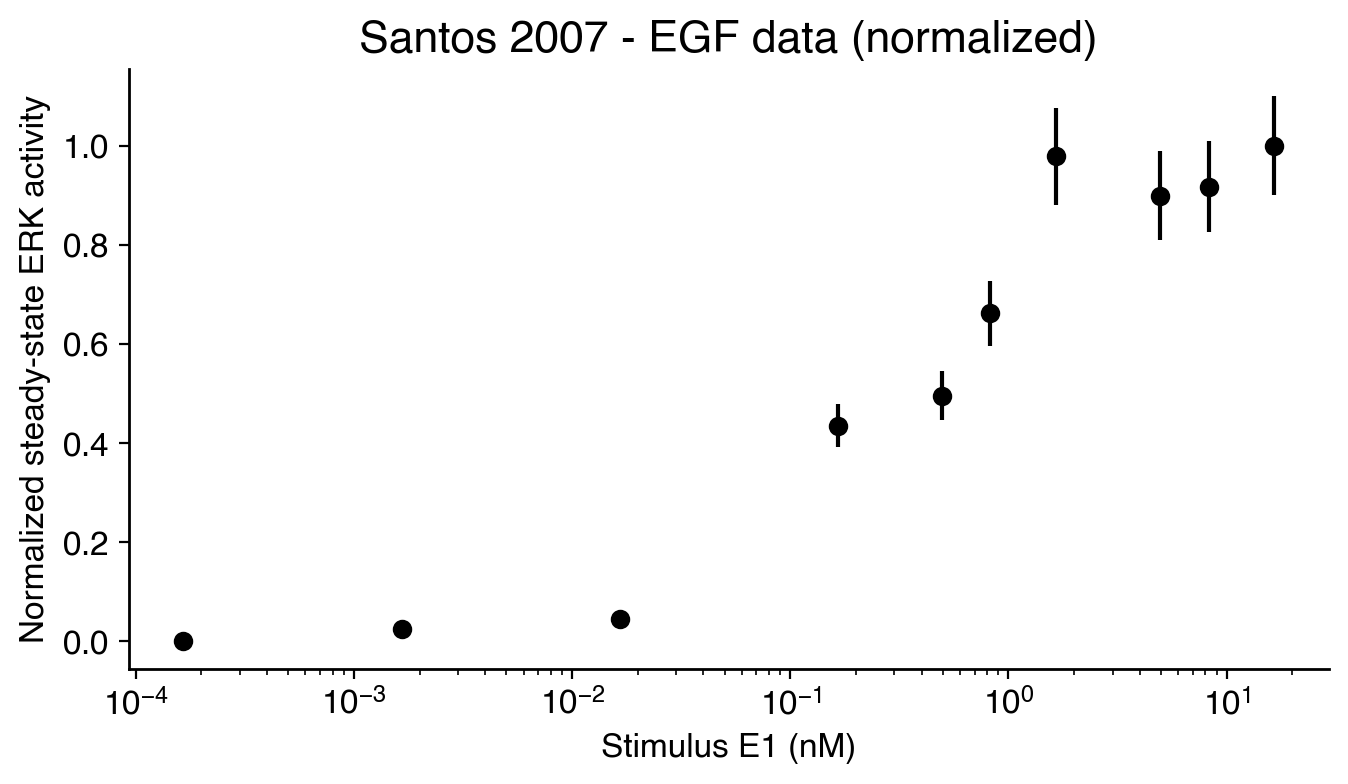

In [49]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
ng_ml_nM_convert = 6.048
# errors = np.array([var_0, var_0_001, var_0_01, var_0_1, var_1, var_3, var_5, var_10, var_30, var_50, var_100])
errors = 0.1*np.ones_like(means['EGF (ng/ml)'][1:])
ax.errorbar((means['EGF (ng/ml)']/ng_ml_nM_convert)[1:], normalized, yerr=errors*normalized, color='k', label='MAPKKK', fmt='o')
ax.set_xlabel('Stimulus E1 (nM)')
ax.set_ylabel('Normalized steady-state ERK activity')
ax.set_xscale('log')
ax.set_title('Santos 2007 - EGF data (normalized)')
fig.savefig('../../figures/MAPK/Santos_2007_deltaNORM_data.pdf', bbox_inches='tight', transparent=True)

# Process Data from Keyes et al. 2020

Figure 1 - C (Cytoplasm) and D (Plasma Membrane)

In [2]:
df_1C = pd.read_excel('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2.xlsx', sheet_name='Figure 1C', 
                      skiprows=2)
df_1D = pd.read_excel('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2.xlsx', sheet_name='Figure 1D',
                      skiprows=1)     

In [3]:
input = 1.653e4 # nM EGF

Cytoplasm

8


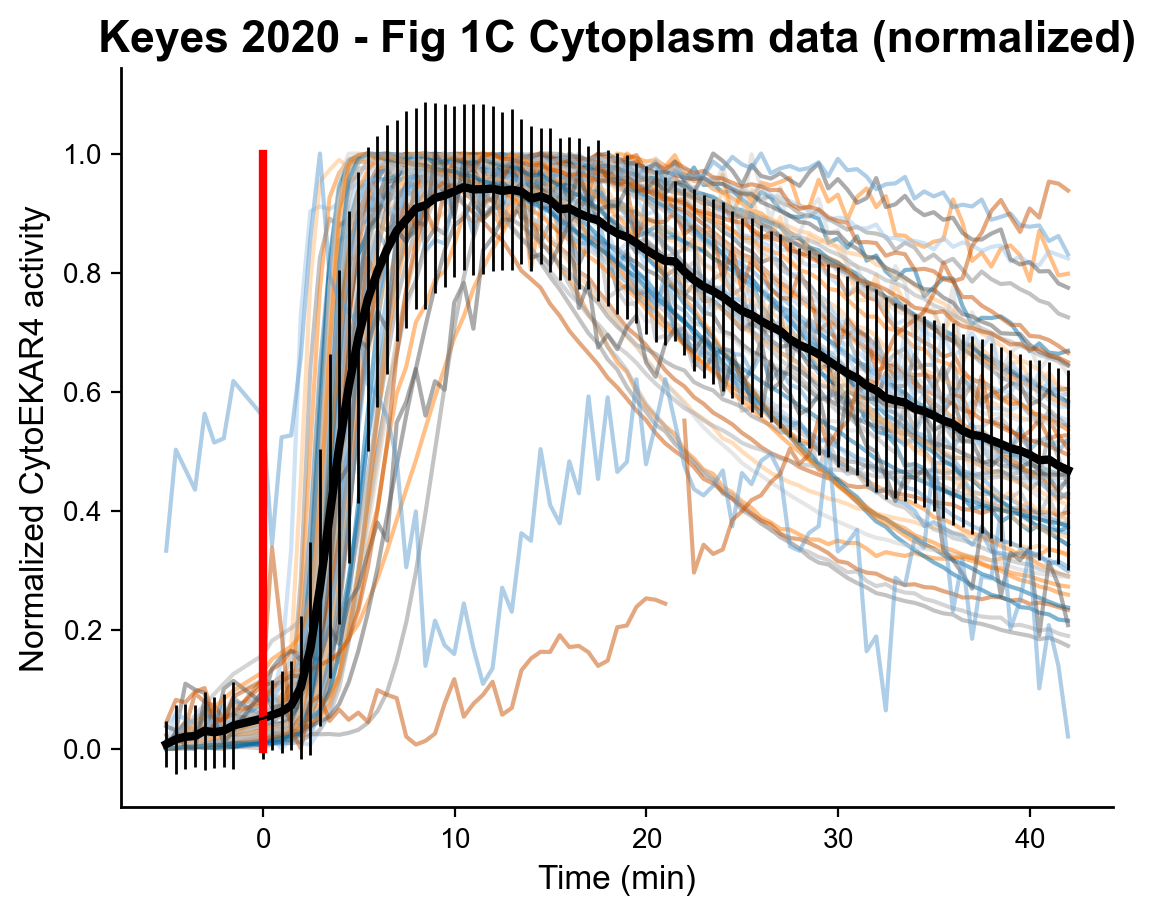

In [27]:
times = df_1C['Time (min)'].to_numpy()
filtered_columns = [col for col in df_1C.columns if 'Cell' in col and '.1' not in col]
C_noInhib = df_1C[filtered_columns].to_numpy()

# normalize each cell's response
normalize = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
normalized_C_noInhib = np.apply_along_axis(normalize, axis=0, arr=C_noInhib)

cyto_mean = np.nanmean(normalized_C_noInhib, axis=1)
cyto_std = np.nanstd(normalized_C_noInhib, axis=1)

T0_idx = np.where(times==0)[0][0]
print(T0_idx)

fig, ax = plt.subplots()
ax.plot(times, normalized_C_noInhib, alpha=0.5)
ax.errorbar(times, cyto_mean, yerr=cyto_std, color='k', linewidth=1)
ax.plot(times, cyto_mean,  color='k', linewidth=3)
ax.plot([times[T0_idx]]*2, [0,1], color='r', linewidth=3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('Normalized CytoEKAR4 activity')
ax.set_title('Keyes 2020 - Fig 1C Cytoplasm data (normalized)')

# save data
df = pd.DataFrame({'stimulus': input, 'response': cyto_mean[T0_idx:], 'time': times[T0_idx:], 'response_std': cyto_std[T0_idx:]})
df.to_csv('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO.csv', index=False)

# convert times to seconds and save as json
data = {'stimulus': [input], 'response': list(cyto_mean[T0_idx:np.min(np.where(np.isnan(times)))]), 'time': list(times[T0_idx:np.min(np.where(np.isnan(times)))]*60), 'response_std': list(cyto_std[T0_idx:np.min(np.where(np.isnan(times)))])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO.json','w') as data_file:
    json.dump(data, data_file)

In [25]:
print(times[T0_idx:])
print(times)

[ 0.          0.47731818  0.97731818  1.47731818  1.97731818  2.47731818
  2.97731818  3.47731818  3.97734848  4.47734848  4.97774242  5.47774242
  5.97774242  6.47774242  6.97774242  7.47774242  7.97774242  8.47774242
  8.97774242  9.47774242  9.97774242 10.47774242 10.97774242 11.47774242
 11.97774242 12.47774242 12.97774242 13.47774242 13.97774242 14.47774242
 14.97774242 15.47774242 15.97774242 16.47774242 16.97774242 17.47774242
 17.97774242 18.47774242 18.97774242 19.47774242 19.97774242 20.47774242
 20.97774242 21.47774242 21.97774242 22.47774242 22.97774242 23.47774242
 23.97774242 24.47774242 24.97774242 25.47774242 25.97774242 26.47774242
 26.97774242 27.47774242 27.97774242 28.47774242 28.97774242 29.47774242
 29.97774242 30.47774242 30.97774242 31.47774242 31.97774242 32.47774242
 32.97774242 33.47774242 33.97774242 34.47774242 34.97774242 35.47774242
 35.97774242 36.47774242 36.97774242 37.47774242 37.97774242 38.47774242
 38.97774242 39.47774242 39.97774242 40.47774242 40

Plasma Membrane

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_60365/871553257.py:9: RuntimeWarning: Mean of empty slice
  PM_mean = np.nanmean(normalized_D_noInhib, axis=1)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6


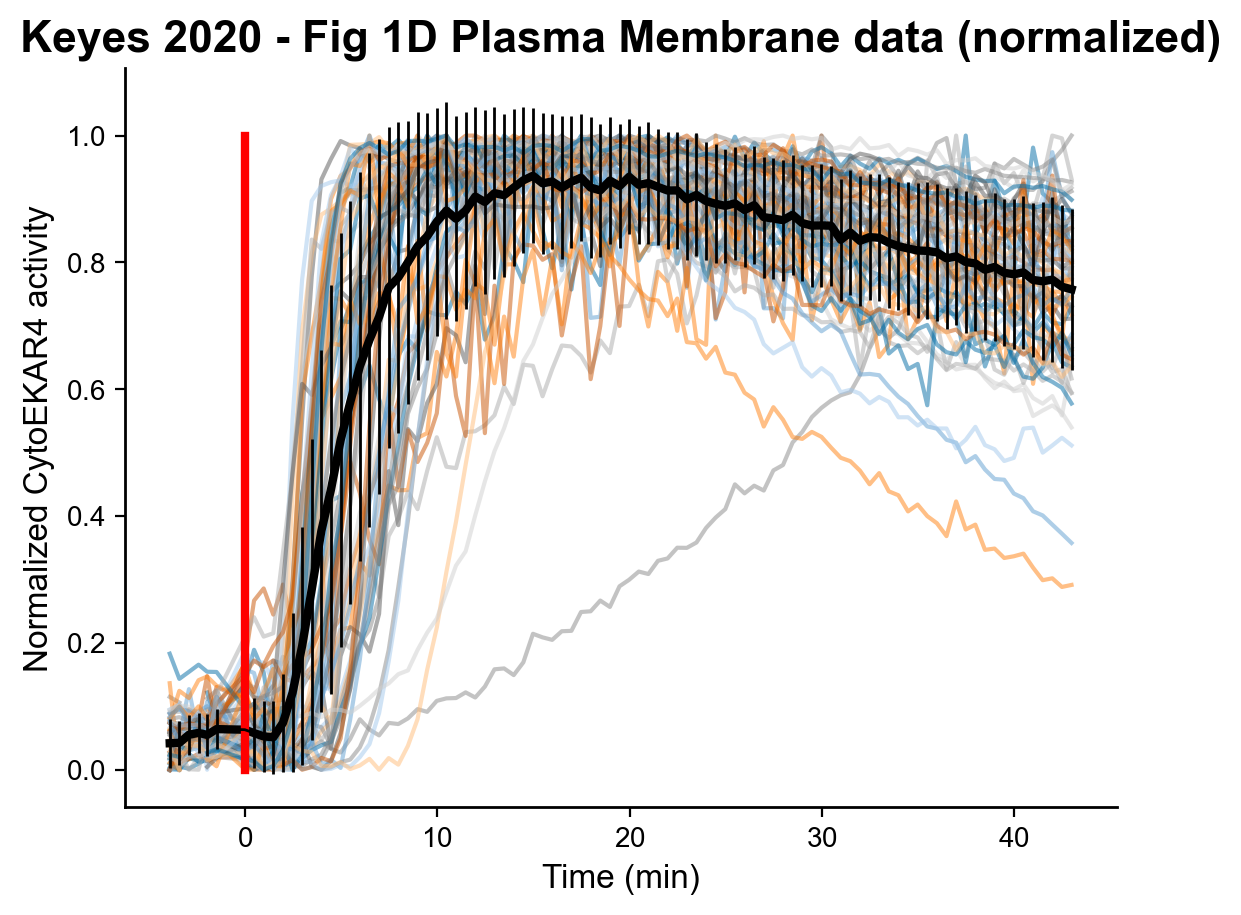

In [26]:
times = df_1D['Time (min)'].to_numpy()
filtered_columns = [col for col in df_1D.columns if 'Cell' in col and '.1' not in col]
D_noInhib = df_1D[filtered_columns].to_numpy()

# normalize each cell's response
normalize = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
normalized_D_noInhib = np.apply_along_axis(normalize, axis=0, arr=D_noInhib)

PM_mean = np.nanmean(normalized_D_noInhib, axis=1)
PM_std = np.nanstd(normalized_D_noInhib, axis=1)

T0_idx = np.where(times==0)[0][0]
print(T0_idx)

fig, ax = plt.subplots()
ax.plot(times, normalized_D_noInhib, alpha=0.5)
ax.errorbar(times, PM_mean, yerr=PM_std, color='k', linewidth=1)
ax.plot(times, PM_mean,  color='k', linewidth=3)
ax.plot([times[T0_idx]]*2, [0,1], color='r', linewidth=3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('Normalized CytoEKAR4 activity')
ax.set_title('Keyes 2020 - Fig 1D Plasma Membrane data (normalized)')

# save data
df = pd.DataFrame({'stimulus': input, 'response': PM_mean[T0_idx:], 'time': times[T0_idx:], 'response_std': PM_std[T0_idx:]})
df.to_csv('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM.csv', index=False)

# convert times to seconds and save as json
data = {'stimulus': [input], 'response': list(PM_mean[T0_idx:np.min(np.where(np.isnan(times)))]), 'time': list(times[T0_idx:np.min(np.where(np.isnan(times)))]*60), 'response_std': list(PM_std[T0_idx:np.min(np.where(np.isnan(times)))])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM.json','w') as data_file:
    json.dump(data, data_file)